# This is the notebook of our final approach

# Preliminaries

## Imports

In [1]:
import numpy as np

#to read/write csv
import pandas as pd

#for SVM
from SVM import fit_SVM_and_predict

#for other features
from tqdm import tqdm
from kernels import phi,Kernel_func

import matplotlib.pyplot as plt

## Constants

In [2]:
split=0.7# We will take split% on data for train set

## Load the data

In [3]:
# Load and standardize features by removing the mean and scaling to unit variance
StandardScaler = lambda df: (df-df.mean())/df.std()

XTrain0 = pd.read_csv('./data/Xtr0_mat100.csv', sep=' ', header=None)
XTrain1 = pd.read_csv('./data/Xtr1_mat100.csv', sep=' ', header=None)
XTrain2 = pd.read_csv('./data/Xtr2_mat100.csv', sep=' ', header=None)

# Standardize the Test features using the mean and std of the TRAIN features
XTest0 = (pd.read_csv('./data/Xte0_mat100.csv', sep=' ', header=None)-XTrain0.mean())/XTrain0.std()
XTest1 = (pd.read_csv('./data/Xte1_mat100.csv', sep=' ', header=None)-XTrain1.mean())/XTrain1.std()
XTest2 = (pd.read_csv('./data/Xte2_mat100.csv', sep=' ', header=None)-XTrain2.mean())/XTrain2.std()

YTrain0 = pd.read_csv('./data/Ytr0.csv', usecols = ['Bound'])
YTrain1 = pd.read_csv('./data/Ytr1.csv', usecols = ['Bound'])
YTrain2 = pd.read_csv('./data/Ytr2.csv', usecols = ['Bound'])

XTrain0_ATGC = pd.read_csv('./data/Xtr0.csv', sep=' ', header=None)
XTrain1_ATGC = pd.read_csv('./data/Xtr1.csv', sep=' ', header=None)
XTrain2_ATGC = pd.read_csv('./data/Xtr2.csv', sep=' ', header=None)

XTest0_ATGC = pd.read_csv('./data/Xte0.csv', sep=' ', header=None)
XTest1_ATGC = pd.read_csv('./data/Xte1.csv', sep=' ', header=None)
XTest2_ATGC = pd.read_csv('./data/Xte2.csv', sep=' ', header=None)


# Standardize Train features
XTrain0 = StandardScaler(XTrain0)
XTrain1 = StandardScaler(XTrain1)
XTrain2 = StandardScaler(XTrain2)

# Spectruc Kernel

## Generate features

In [4]:
###################################################################################################
#                                           SPECTRUM KERNEL                                       #
###################################################################################################
k=8 #length of subsequences considered

print('dimension of features:{}'.format(4**k))
XTrain0KF=np.zeros([len(XTrain0_ATGC)-1,4**k]) 
XTrain1KF=np.zeros([len(XTrain1_ATGC)-1,4**k])
XTrain2KF=np.zeros([len(XTrain2_ATGC)-1,4**k])

XTest0KF=np.zeros([len(XTest0_ATGC)-1,4**k])
XTest1KF=np.zeros([len(XTest1_ATGC)-1,4**k])
XTest2KF=np.zeros([len(XTest2_ATGC)-1,4**k])

ATGC=[XTrain0_ATGC,XTrain1_ATGC,XTrain2_ATGC,XTest0_ATGC,XTest1_ATGC,XTest2_ATGC]
KF=[XTrain0KF,XTrain1KF,XTrain2KF,XTest0KF,XTest1KF,XTest2KF]  #KF stands for kernel_features

for data in tqdm(range(6)):
    for idx,sequence in enumerate(ATGC[data][0][1:]): #[1:] pour ne pas prendre la ligne 'Id,seq'
        x = sequence.split(',')[1]
        KF[data][idx,:]=phi(x,k,kernel='spectrum_efficient')

# Standardize Train features
XTrain0KF = StandardScaler(XTrain0KF)
XTrain1KF = StandardScaler(XTrain1KF)
XTrain2KF = StandardScaler(XTrain2KF)


XTest0KF = XTest0KF-XTrain0KF.mean()/XTrain0KF.std()
XTest1KF = XTest1KF-XTrain1KF.mean()/XTrain1KF.std()
XTest2KF = XTest2KF-XTrain2KF.mean()/XTrain2KF.std()

  0%|          | 0/6 [00:00<?, ?it/s]

dimension of features:65536


100%|██████████| 6/6 [00:04<00:00,  1.28it/s]


In [54]:
XTrain0KF.shape, XTrain0.shape

((2000, 65536), (2000, 100))

## Generate Kernel and gram matrices

In [5]:
K0_SK = np.dot(XTrain0KF[:int(len(XTrain0)*split)],XTrain0KF[:int(len(XTrain0)*split)].T) 
G0_SK = np.dot(XTrain0KF[int(len(XTrain0)*split):], XTrain0KF[:int(len(XTrain0)*split)].T)
Y0 = np.squeeze(np.array(YTrain0[:int(len(XTrain0)*split)]))

K1_SK = np.dot(XTrain1KF[:int(len(XTrain1)*split)],XTrain1KF[:int(len(XTrain1)*split)].T) 
G1_SK = np.dot(XTrain1KF[int(len(XTrain1)*split):], XTrain1KF[:int(len(XTrain1)*split)].T)
Y1 = np.squeeze(np.array(YTrain1[:int(len(XTrain1)*split)]))

K2_SK = np.dot(XTrain2KF[:int(len(XTrain0)*split)],XTrain2KF[:int(len(XTrain2)*split)].T) 
G2_SK = np.dot(XTrain2KF[int(len(XTrain2)*split):], XTrain2KF[:int(len(XTrain2)*split)].T)
Y2 = np.squeeze(np.array(YTrain2[:int(len(XTrain2)*split)]))

## hyperparameter selection and model assessment

In [33]:
from scipy.stats import logistic

best_lambda0, best_lambda1, best_lambda2 = 1, 1, 1
best_accuracy = [0, 0, 0]
lambdaa_list = np.logspace(-8, 4, 10)

loss_vs_lambda =[[], [], []]
accuracy_vs_lambda =[[], [], []]

for i, (K, G, Y, XTrain, Ytrain) in enumerate(
    zip(
        [K0_SK, K1_SK, K2_SK],
        [G0_SK, G1_SK, G2_SK],
        [Y0, Y1, Y2],
        [XTrain0, XTrain1, XTrain2],
        [YTrain0, YTrain1, YTrain2],

    )
):

    for lambdaa in lambdaa_list:
        # Predictions -1/1
        p = fit_SVM_and_predict(K=K, gram=G, Y=Y, C=lambdaa, get_proba=True)
        p = p/(p.max()-p.min())

        # Predictions 0/1
        predictions = (1 + np.sign(p)) / 2
        proba = logistic.cdf(p)
        # Asses the predictions
        y_true = np.array(Ytrain["Bound"][int(len(XTrain) * split) :])
       
        # Compute the accuracy
        accuracy = 100 * (1 - np.mean(abs(y_true - predictions)))
        loss = (- y_true*np.log(proba) - (1-y_true)*np.log(1-proba)).mean()
        loss_vs_lambda[i].append(loss)
        accuracy_vs_lambda[i].append(accuracy)


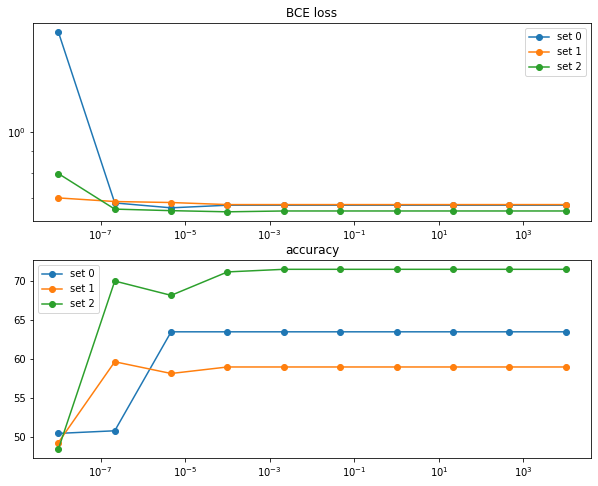

63.50% accuracy on dataset 0 for lambda = 4.641588833612773e-06
59.00% accuracy on dataset 1 for lambda = 0.046415888336127725
71.17% accuracy on dataset 2 for lambda = 0.0001


In [34]:
fig, axs = plt.subplots(2, 1, figsize = (10,8))
loss_vs_lambda = np.array(loss_vs_lambda)
accuracy_vs_lambda = np.array(accuracy_vs_lambda)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[1].set_xscale("log")

for i in range(3):
    axs[0].plot(lambdaa_list, loss_vs_lambda[i] - 1e-5*accuracy_vs_lambda[i], "-o", label=f"set {i}")
    axs[1].plot(lambdaa_list, accuracy_vs_lambda[i], "-o", label=f"set {i}")
axs[0].set_title('BCE loss')
axs[1].set_title('accuracy')
axs[0].legend()
axs[1].legend()

plt.show()

best_lambda_idx = np.nanargmin(loss_vs_lambda - 1e-5*accuracy_vs_lambda[i], axis=1)
for i, idx in enumerate(best_lambda_idx):
    print(
        "{:.2f}% accuracy on dataset {} for lambda = {}".format(
            accuracy_vs_lambda[i][idx], i, lambdaa_list[idx]
        )
    )

best_lambda0, best_lambda1, best_lambda2 = (
    lambdaa_list[best_lambda_idx[0]],
    lambdaa_list[best_lambda_idx[1]],
    lambdaa_list[best_lambda_idx[2]],
)


In [27]:
loss_vs_lambda

array([[1.71599699, 0.66444602, 0.67292604, 0.67292814],
       [0.69989818, 0.67590776, 0.67517822, 0.67517821],
       [0.7982178 , 0.64757352, 0.65239911, 0.65240029]])

## Generate csv file to upload on Kaggle for spectrum kernel

In [7]:
#Dataset 0
K0_SK = np.dot(XTrain0KF,XTrain0KF.T)  
G0_SK = np.dot(XTest0KF, XTrain0KF.T)
Y0 = np.squeeze(np.array(YTrain0))
p0 = fit_SVM_and_predict(K=K0_SK,gram=G0_SK,Y=Y0,C=best_lambda0,get_proba=False)

#Dataset 1
K1_SK = np.dot(XTrain1KF,XTrain1KF.T)  
G1_SK = np.dot(XTest1KF, XTrain1KF.T)
Y1 = np.squeeze(np.array(YTrain1))
p1 = fit_SVM_and_predict(K=K1_SK,gram=G1_SK,Y=Y1,C=best_lambda1,get_proba=False)

#Dataset 2
K2_SK = np.dot(XTrain2KF,XTrain2KF.T)  
G2_SK = np.dot(XTest2KF, XTrain2KF.T)
Y2 = np.squeeze(np.array(YTrain2))
p2 = fit_SVM_and_predict(K=K2_SK,gram=G2_SK,Y=Y2,C=best_lambda2,get_proba=False)


#Predictions 0/1
predictions0 = (1+np.sign(p0))/2
predictions1 = (1+np.sign(p1))/2
predictions2 = (1+np.sign(p2))/2

# Creation of the Kaggle submission file
df0 = pd.DataFrame({'Id': np.arange(1000), 'Bound': predictions0.squeeze().astype(int)})
df1 = pd.DataFrame({'Id': np.arange(1000,2000), 'Bound': predictions1.squeeze().astype(int)})
df2 = pd.DataFrame({'Id': np.arange(2000,3000), 'Bound': predictions2.squeeze().astype(int)})
dfResult = pd.concat([df0,df1,df2])
dfResult.to_csv('./data/submissionSVM.csv', index=False)

NameError: name 'XTrain0KF' is not defined

# GLOBAL ALIGNMENT KERNEL with BIOPYTHON

## Useful functions (the mapping $\phi$ is not explicit)

In [36]:
###################################################################################################
#                                    GLOBAL ALIGNMENT KERNEL                                      #
###################################################################################################
def construct_KERNELmat(XATGC):
    XATGC=XATGC[0]
    Kmat=np.zeros([len(XATGC),len(XATGC)])
    
    for idx1,sequence1 in enumerate(XATGC):
        x1 = sequence1.split(',')[1] #keep only the ATGC sequence
        for idx2,sequence2 in enumerate(XATGC):
            x2 = sequence2.split(',')[1]
            if idx1>=idx2:#because the matrice is symmetric ==> reduce computation time
                Kmat[idx1,idx2]=Kernel_func(x1,x2,kernel='bio')
                Kmat[idx2,idx1]=Kmat[idx1,idx2]
    
    return Kmat

def construct_Grammat(XTrainATGC,XTestATGC):
    
    XTestATGC=XTestATGC[0]
    XTrainATGC=XTrainATGC[0]
    Gmat=np.zeros([len(XTestATGC),len(XTrainATGC)])
    
    for idx1,sequence1 in enumerate(XTestATGC):
        x1 = sequence1.split(',')[1]
        for idx2,sequence2 in enumerate(XTrainATGC):
            x2 = sequence2.split(',')[1]
            Gmat[idx1,idx2]=Kernel_func(x1,x2,kernel='bio')
    
    return Gmat

## Asses the model

In [37]:
# construct validation matrices

K0_AK = construct_KERNELmat(
    XTrain0_ATGC[1 : int(len(XTrain0) * split) + 1]
)  # takes 3min
print("K0 constructed")
K1_AK = construct_KERNELmat(
    XTrain1_ATGC[1 : int(len(XTrain1) * split) + 1]
)  # takes 3min
print("K1 constructed")
K2_AK = construct_KERNELmat(
    XTrain2_ATGC[1 : int(len(XTrain2) * split) + 1]
)  # takes 3min
print("K2 constructed")
G0_AK = construct_Grammat(
    XTrain0_ATGC[1 : int(len(XTrain0) * split) + 1],
    XTrain0_ATGC[1 + int(len(XTrain0) * split) :],
)
print("G0 constructed")
G1_AK = construct_Grammat(
    XTrain1_ATGC[1 : int(len(XTrain1) * split) + 1],
    XTrain1_ATGC[1 + int(len(XTrain1) * split) :],
)
print("G1 constructed")
G2_AK = construct_Grammat(
    XTrain2_ATGC[1 : int(len(XTrain2) * split) + 1],
    XTrain2_ATGC[1 + int(len(XTrain2) * split) :],
)
print("G2 constructed")


Y0 = np.squeeze(np.array(YTrain0[: int(len(XTrain0) * split)]))
Y1 = np.squeeze(np.array(YTrain1[: int(len(XTrain1) * split)]))
Y2 = np.squeeze(np.array(YTrain2[: int(len(XTrain2) * split)]))


K0 constructed
K1 constructed
K2 constructed
G0 constructed
G1 constructed
G2 constructed


In [38]:
K0=np.exp(K0_AK/120)
K1=np.exp(K1_AK/120)
K2=np.exp(K2_AK/120)
G0=np.exp(G0_AK/120)
G1=np.exp(G1_AK/120)
G2=np.exp(G2_AK/120)

In [40]:
from scipy.stats import logistic

lambdaa_list = np.logspace(-3,3, 10)

loss_vs_lambda =[[], [], []]
accuracy_vs_lambda =[[], [], []]

for i, (K, G, Y, XTrain,Ytrain) in enumerate(
    zip(
        [K0, K1, K2],
        [G0, G1, G2],
        [Y0, Y1, Y2],
        [XTrain0, XTrain1, XTrain2],
        [YTrain0, YTrain1, YTrain2],

    )
):

    for lambdaa in lambdaa_list:
        # Predictions -1/1
        p = fit_SVM_and_predict(K=K, gram=G, Y=Y, C=lambdaa, get_proba=True)
        p = p/(p.max()-p.min())

        # Predictions 0/1
        predictions = (1 + np.sign(p)) / 2
        proba = logistic.cdf(p)
        # Asses the predictions
        y_true = np.array(Ytrain["Bound"][int(len(XTrain) * split) :])
       
        # Compute the accuracy
        accuracy = 100 * (1 - np.mean(abs(y_true - predictions)))
        loss = (- y_true*np.log(proba) - (1-y_true)*np.log(1-proba)).mean()
        loss_vs_lambda[i].append(loss)
        accuracy_vs_lambda[i].append(accuracy)


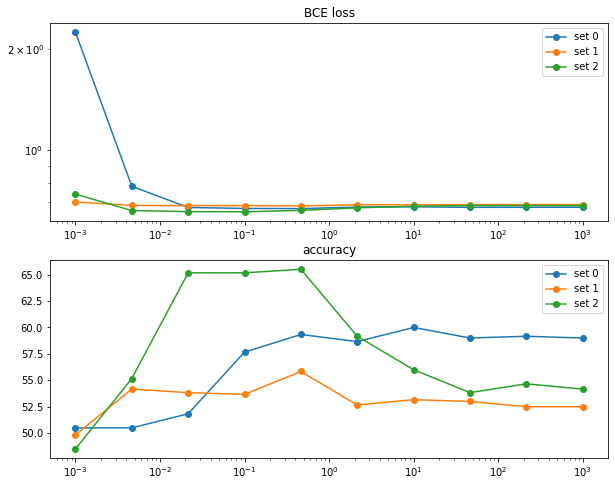

59.33% accuracy on dataset 0 for lambda = 0.46415888336127775
55.83% accuracy on dataset 1 for lambda = 0.46415888336127775
65.17% accuracy on dataset 2 for lambda = 0.1


In [42]:
fig, axs = plt.subplots(2, 1, figsize = (10,8))
loss_vs_lambda = np.array(loss_vs_lambda)
accuracy_vs_lambda = np.array(accuracy_vs_lambda)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[1].set_xscale("log")

for i in range(3):
    axs[0].plot(lambdaa_list, loss_vs_lambda[i] - 1e-5*accuracy_vs_lambda[i], "-o", label=f"set {i}")
    axs[1].plot(lambdaa_list, accuracy_vs_lambda[i], "-o", label=f"set {i}")
axs[0].set_title('BCE loss')
axs[1].set_title('accuracy')
axs[0].legend()
axs[1].legend()

plt.show()

best_lambda_idx = np.nanargmin(loss_vs_lambda- 1e-5*accuracy_vs_lambda[i], axis=1)
for i, idx in enumerate(best_lambda_idx):
    print(
        "{:.2f}% accuracy on dataset {} for lambda = {}".format(
            accuracy_vs_lambda[i][idx], i, lambdaa_list[idx]
        )
    )

best_lambda0, best_lambda1, best_lambda2 = (
    lambdaa_list[best_lambda_idx[0]],
    lambdaa_list[best_lambda_idx[1]],
    lambdaa_list[best_lambda_idx[2]],
)


# Combing AK + SK

In [50]:
# K0 = np.exp(K0_AK / 120)/ 0.46 + K0_SK/4.64/1e-6
# G0 = np.exp(G0_AK / 120)/ 0.46 + G0_SK/4.64/1e-6

# K1 = np.exp(K1_AK / 120)/ 0.46 + K1_SK /  0.046
# G1 = np.exp(G1_AK / 120)/ 0.46 + G1_SK /  0.046

# K2 = np.exp(K2_AK / 120)/0.1 + K2_SK / 0.0001
# G2 = np.exp(G2_AK / 120)/0.1 + G2_SK / 0.0001

K0 = np.exp(K0_AK / 120) + K0_SK
G0 = np.exp(G0_AK / 120) + G0_SK

K1 = np.exp(K1_AK / 120) + K1_SK 
G1 = np.exp(G1_AK / 120) + G1_SK 

K2 = np.exp(K2_AK / 120) + K2_SK 
G2 = np.exp(G2_AK / 120) + G2_SK 



In [51]:
from scipy.stats import logistic

lambdaa_list = np.logspace(-3,3, 10)

loss_vs_lambda =[[], [], []]
accuracy_vs_lambda =[[], [], []]

for i, (K, G, Y, XTrain,Ytrain) in enumerate(
    zip(
        [K0, K1, K2],
        [G0, G1, G2],
        [Y0, Y1, Y2],
        [XTrain0, XTrain1, XTrain2],
        [YTrain0, YTrain1, YTrain2],

    )
):

    for lambdaa in lambdaa_list:
        # Predictions -1/1
        p = fit_SVM_and_predict(K=K, gram=G, Y=Y, C=lambdaa, get_proba=True)
        p = p/(p.max()-p.min())

        # Predictions 0/1
        predictions = (1 + np.sign(p)) / 2
        proba = logistic.cdf(p)
        # Asses the predictions
        y_true = np.array(Ytrain["Bound"][int(len(XTrain) * split) :])
       
        # Compute the accuracy
        accuracy = 100 * (1 - np.mean(abs(y_true - predictions)))
        loss = (- y_true*np.log(proba) - (1-y_true)*np.log(1-proba)).mean()
        loss_vs_lambda[i].append(loss)
        accuracy_vs_lambda[i].append(accuracy)


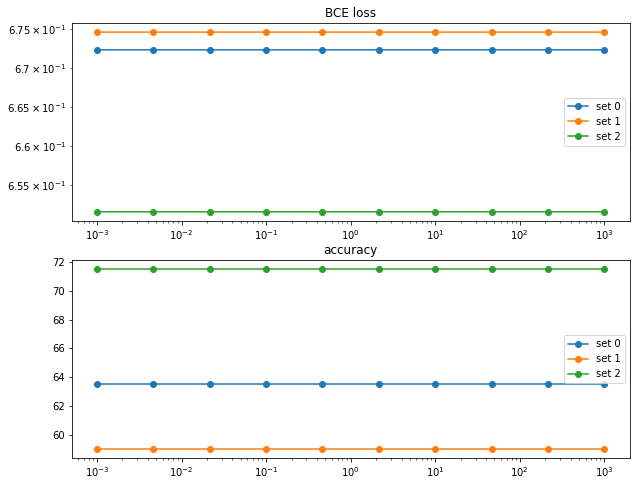

63.50% accuracy on dataset 0 for lambda = 0.46415888336127775
59.00% accuracy on dataset 1 for lambda = 10.0
71.50% accuracy on dataset 2 for lambda = 0.46415888336127775


In [52]:
fig, axs = plt.subplots(2, 1, figsize = (10,8))
loss_vs_lambda = np.array(loss_vs_lambda)
accuracy_vs_lambda = np.array(accuracy_vs_lambda)

axs[0].set_xscale("log")
axs[0].set_yscale("log")

axs[1].set_xscale("log")

for i in range(3):
    axs[0].plot(lambdaa_list, loss_vs_lambda[i] - 1e-5*accuracy_vs_lambda[i], "-o", label=f"set {i}")
    axs[1].plot(lambdaa_list, accuracy_vs_lambda[i], "-o", label=f"set {i}")
axs[0].set_title('BCE loss')
axs[1].set_title('accuracy')
axs[0].legend()
axs[1].legend()

plt.show()

best_lambda_idx = np.nanargmin(loss_vs_lambda- 1e-5*accuracy_vs_lambda[i], axis=1)
for i, idx in enumerate(best_lambda_idx):
    print(
        "{:.2f}% accuracy on dataset {} for lambda = {}".format(
            accuracy_vs_lambda[i][idx], i, lambdaa_list[idx]
        )
    )

best_lambda0, best_lambda1, best_lambda2 = (
    lambdaa_list[best_lambda_idx[0]],
    lambdaa_list[best_lambda_idx[1]],
    lambdaa_list[best_lambda_idx[2]],
)


## Generate csv file to upload on Kaggle for GLOBAL ALIGNMENT + Spectrum kernel 

In [51]:
K0=np.exp(construct_KERNELmat(XTrain0_ATGC[1:])/120)+K0_SK #takes 3min
print('K0 constructed')
K1=np.exp(construct_KERNELmat(XTrain1_ATGC[1:])/120)+K1_SK #takes 3min
print('K1 constructed')
K2=np.exp(construct_KERNELmat(XTrain2_ATGC[1:])/120)+K2_SK #takes 3min
print('K2 constructed')
G0=np.exp(construct_Grammat(XTrain0_ATGC[1:],XTest0_ATGC[1:])/120)+G0_SK
print('G0 constructed')
G1=np.exp(construct_Grammat(XTrain1_ATGC[1:],XTest1_ATGC[1:])/120)+G1_SK
print('G1 constructed')
G2=np.exp(construct_Grammat(XTrain2_ATGC[1:],XTest2_ATGC[1:])/120)+G2_SK
print('G2 constructed')


Y0 = np.squeeze(np.array(YTrain0))
p0 = fit_SVM_and_predict(K=K0,gram=G0,Y=Y0,C=best_lambda0,get_proba=False)

Y1 = np.squeeze(np.array(YTrain1))
p1 = fit_SVM_and_predict(K=K1,gram=G1,Y=Y1,C=best_lambda1,get_proba=False)


Y2 = np.squeeze(np.array(YTrain2))
p2 = fit_SVM_and_predict(K=K2,gram=G2,Y=Y2,C=best_lambda2,get_proba=False)


#Predictions 0/1
predictions0 = (1+np.sign(p0))/2
predictions1 = (1+np.sign(p1))/2
predictions2 = (1+np.sign(p2))/2

# Creation of the Kaggle submission file
df0 = pd.DataFrame({'Id': np.arange(1000), 'Bound': predictions0.squeeze().astype(int)})
df1 = pd.DataFrame({'Id': np.arange(1000,2000), 'Bound': predictions1.squeeze().astype(int)})
df2 = pd.DataFrame({'Id': np.arange(2000,3000), 'Bound': predictions2.squeeze().astype(int)})
dfResult = pd.concat([df0,df1,df2])
dfResult.to_csv('./data/submissionSVM.csv', index=False)

K0 constructed
K1 constructed
K2 constructed
G0 constructed
G1 constructed
G2 constructed
